# IPL: Mining, Modeling and Predicting

## Dataset source

https://www.kaggle.com/manasgarg/ipl/data

## Goals

- Finding the best lineup and batting order for each team
- Predicting the winner or results of next IPL season
- Deiciding Man-of-the-Match for each match
- Creating a simulation game that simulates matches based on picked team, batting line-up chosen and bowler chosen.

## Mount Drive

You need to download those two csv files and upload them to drive on your end as well.

The below code will ask you for access to your google drive so that it can find those csv files

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time

## Preprocessing

In [0]:
deliveries_path = "/content/drive/My Drive/deliveries.csv"
matches_path = "/content/drive/My Drive/matches.csv"

deliveries_df = pd.read_csv(deliveries_path)
matches_df = pd.read_csv(matches_path)

In [27]:
deliveries_df.iloc[0:5,] # iloc is a way to index the dataframe by row(s) and column(s) as you can see

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN


In [28]:
deliveries_df.columns # These are the names of the columns you can use to index the df

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [29]:
# Converting datatypes of columns to what they should be
deliveries_df = deliveries_df.astype({"batsman_runs":"int32",
                      "over":"int32",
                      "ball":"int32",
                      "bye_runs":"int32",
                      "noball_runs":"int32",
                      "wide_runs":"int32",
                      "penalty_runs":"int32",
                      "legbye_runs":"int32",
                      "extra_runs":"int32",
                      "total_runs":"int32"})

deliveries_df.iloc[0:12,]

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN
5,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,6,S Dhawan,DA Warner,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
6,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,7,S Dhawan,DA Warner,TS Mills,0,0,0,1,0,0,0,1,1,NaN,NaN,NaN
7,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,1,S Dhawan,DA Warner,A Choudhary,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN
8,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,2,DA Warner,S Dhawan,A Choudhary,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
9,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,3,DA Warner,S Dhawan,A Choudhary,0,0,0,0,1,0,0,1,1,NaN,NaN,NaN


In [0]:
batsmen_names = set(deliveries_df["batsman"]) # list of all batsmen
batsmen_stats_dict = {}

for batter in batsmen_names:
    batter_data = deliveries_df[deliveries_df["batsman"] == batter]
    innings = len(set(batter_data["match_id"]))

    # Balls Faced = Total balls on strike - no balls - wide balls
    balls_faced = len(batter_data) - len(batter_data[batter_data["noball_runs"] > 0]) - len(batter_data[batter_data["wide_runs"] > 0]) 
    runs_scored = sum(batter_data["batsman_runs"])
    dismissals = len(deliveries_df[deliveries_df["player_dismissed"] == batter])

    run_distribution = batter_data["batsman_runs"].value_counts().to_dict()
    dismissal_distribution = batter_data[batter_data["dismissal_kind"].notna()]["dismissal_kind"].value_counts().to_dict()

    batsmen_stats_dict[batter] = {"Innings":innings,
                                  "Runs": runs_scored,
                                  "Balls Faced": balls_faced,
                                  "Dismissals": dismissals,
                                  "Run Distribution":run_distribution,
                                  "Dismissal Distribution": dismissal_distribution}

In [31]:
batsmen_df = pd.DataFrame(batsmen_stats_dict).T
batsmen_df = pd.concat([batsmen_df.drop(["Run Distribution"], axis=1), batsmen_df["Run Distribution"].apply(pd.Series)], axis=1)
batsmen_df = pd.concat([batsmen_df.drop(["Dismissal Distribution"], axis=1), batsmen_df["Dismissal Distribution"].apply(pd.Series)], axis=1)
batsmen_df.fillna(0, inplace=True)
batsmen_df = batsmen_df.astype(int)

#Renaming
batsmen_df.reset_index(inplace=True)
colnames = batsmen_df.columns.values
colnames[0] = "Name"
batsmen_df.columns = colnames

# Additional Columns
batsmen_df["Average"] = batsmen_df["Runs"] / batsmen_df["Dismissals"]
batsmen_df["Strike Rate"] = 100 * batsmen_df["Runs"] / batsmen_df["Balls Faced"]

# Display settings
    # decimal display format
pd.options.display.float_format = '{:.2f}'.format
# Note the below three columns are not actually dropped, just omitted from the display 
batsmen_df.drop(["retired hurt", "hit wicket", "obstructing the field"], axis=1).iloc[0:5, ]

,Name,Innings,Runs,Balls Faced,Dismissals,0,1,2,3,4,5,6,bowled,caught,run out,lbw,caught and bowled,stumped,Average,Strike Rate
0,RR Raje,5,20,18,1,6,10,0,0,1,0,1,1,0,0,0,0,0,20.00,111.11
1,AM Rahane,105,3057,2531,91,1001,1039,168,14,320,0,60,15,55,7,6,5,3,33.59,120.78
2,AJ Finch,64,1604,1226,59,554,407,77,3,170,0,59,18,29,2,3,2,3,27.19,130.83
3,S Gopal,3,14,27,2,16,10,0,0,1,0,0,0,1,1,0,0,0,7.00,51.85
4,CA Pujara,22,390,390,19,200,133,15,1,50,0,4,4,12,1,1,0,0,20.53,100.00


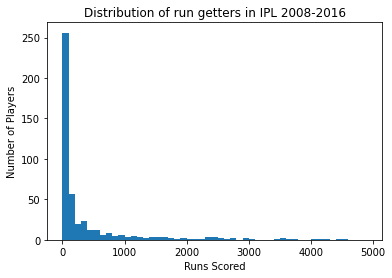

In [32]:
plt.hist(batsmen_df["Runs"], bins=np.arange(0,5000,100))
plt.xlabel("Runs Scored")
plt.ylabel("Number of Players")
plt.title("Distribution of run getters in IPL 2008-2016")
plt.show()

In [0]:
top_n = 50
high_scorers = batsmen_df.sort_values(by=["Runs"], ascending=False)
high_scorers = high_scorers.iloc[0:top_n, ] # top 50 run getters only

## Types of Batsmen: Preliminary Analysis

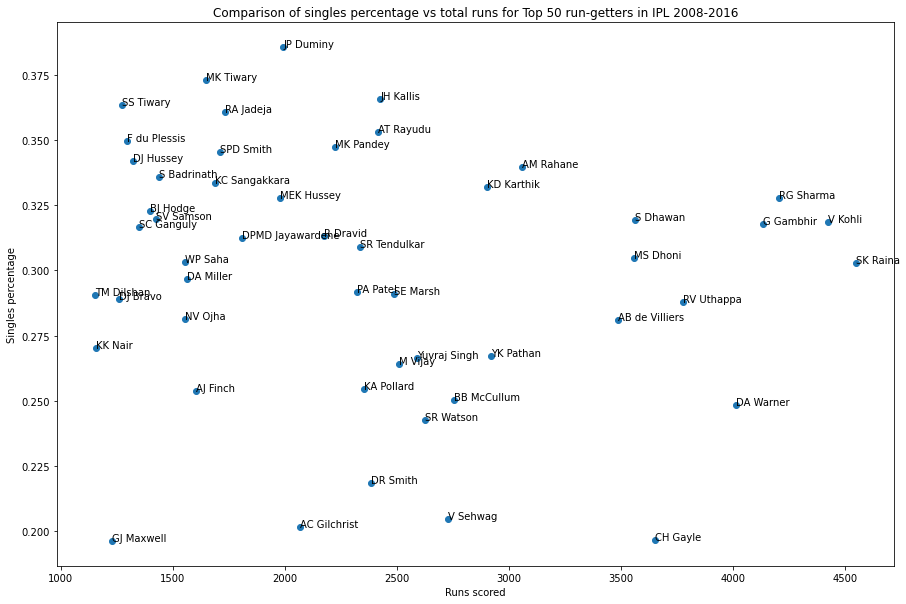

In [34]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(high_scorers["Runs"], high_scorers[1] / high_scorers["Runs"])
ax.set_xlabel("Runs scored")
ax.set_ylabel("Singles percentage")
ax.set_title("Comparison of singles percentage vs total runs for Top 50 run-getters in IPL 2008-2016")

for i, batter in enumerate(high_scorers["Name"]):
    ax.annotate(batter, (high_scorers["Runs"].iloc[i], high_scorers[1].iloc[i] / high_scorers["Runs"].iloc[i]))

fig.show()

As expected, Chris Gayle is on the bottom right, Virat Kohli is in the top right, and more traditional batsmen like Sangakarra are in the top left.

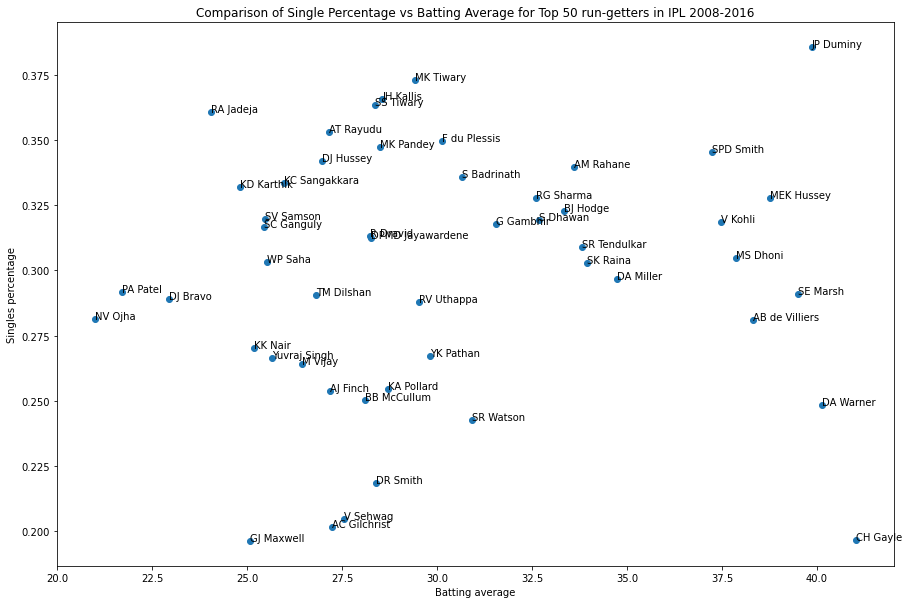

In [35]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(high_scorers["Average"], high_scorers[1] / high_scorers["Runs"])
ax.set_xlabel("Batting average")
ax.set_ylabel("Singles percentage")
ax.set_title("Comparison of Single Percentage vs Batting Average for Top 50 run-getters in IPL 2008-2016")

for i, batter in enumerate(high_scorers["Name"]):
    ax.annotate(batter, (high_scorers["Average"].iloc[i], high_scorers[1].iloc[i] / high_scorers["Runs"].iloc[i]))

fig.show()

This is even more prominent now as Chris Gayle is in the extreme bottom right, and accumulators like Sangakarra, Kallis or even Rayudu are on the top left. Blasters like Maxwell, Sehwag and Gilchrist are also where we expect, hovering closer to bottom left.

### Run Distributions

Piechart of run distributions

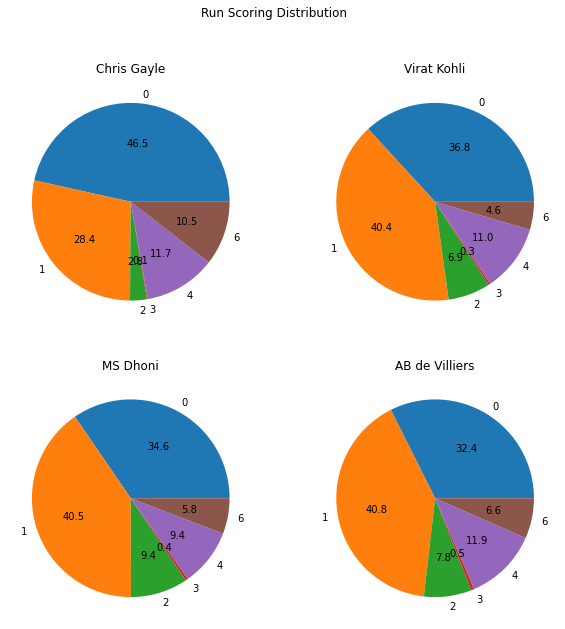

In [36]:
gayle = batsmen_stats_dict["CH Gayle"]["Run Distribution"]
kohli = batsmen_stats_dict["V Kohli"]["Run Distribution"]
dhoni = batsmen_stats_dict["MS Dhoni"]["Run Distribution"]
abd = batsmen_stats_dict["AB de Villiers"]["Run Distribution"]

order = sorted(gayle.keys())

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
ax1.pie([v for k,v in sorted(gayle.items())], labels=[int(k) for k in order], autopct='%1.1f')
ax1.set_title("Chris Gayle")

ax2.pie([v for k,v in sorted(kohli.items())], labels=[int(k) for k in order], autopct='%1.1f')
ax2.set_title("Virat Kohli")

ax3.pie([v for k,v in sorted(dhoni.items())], labels=[int(k) for k in order], autopct='%1.1f')
ax3.set_title("MS Dhoni")

ax4.pie([v for k,v in sorted(abd.items())], labels=[int(k) for k in order], autopct='%1.1f')
ax4.set_title("AB de Villiers")

fig.suptitle("Run Scoring Distribution")
fig.show()


Notice the remarkable difference between Gayle and the rest. Gayle has significantly more dots and significantly fewer singles but has hit significantly more sixes too.

## Bowler Performance: Preliminary Analysis

In [37]:
deliveries_df.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [0]:
dismissal_kinds = set(deliveries_df['dismissal_kind'])
bowler_dismissals = ['bowled','caught','caught and bowled', 'lbw', 'stumped']

In [0]:
bowler_names = list(set(deliveries_df['bowler']))
bowler_stats_dict = {}

for bowler in bowler_names:
    bowler_data = deliveries_df[deliveries_df['bowler'] == bowler]

    matches = len(set(bowler_data["match_id"]))
    
    noballs = len(bowler_data[bowler_data["noball_runs"] > 0])
    wides = len(bowler_data[bowler_data["wide_runs"] > 0])

    # Total runs conceded = runs off bat + noballs + wides
    runs_conceded = np.sum(bowler_data['batsman_runs']) + np.sum(bowler_data['noball_runs']) + np.sum(bowler_data['wide_runs'])
    # Num balls = balls bowled - no balls - wides
    legal_balls_bowled = len(bowler_data) - noballs - wides
    
    dismissal_distribution = bowler_data[bowler_data["dismissal_kind"].notna()]["dismissal_kind"].value_counts().to_dict()
    wickets_taken = 0
    for bd in bowler_dismissals:
        if bd in dismissal_distribution.keys():
            wickets_taken += dismissal_distribution[bd]

    run_distribution = bowler_data["batsman_runs"].value_counts().to_dict()
    
    bowler_stats_dict[bowler] = {"Matches": matches,
                                 "Wickets": wickets_taken,
                                 "Balls Bowled": legal_balls_bowled,
                                 "Runs Conceded": runs_conceded,
                                 "Dismissal Distribution": dismissal_distribution,
                                 "Run Distribution": run_distribution,
                                 "No Balls": noballs,
                                 "Wides": wides}



In [40]:
bowlers_df = pd.DataFrame(bowler_stats_dict).T
bowlers_df = pd.concat([bowlers_df.drop(["Dismissal Distribution"], axis=1), bowlers_df["Dismissal Distribution"].apply(pd.Series)], axis=1)
bowlers_df = pd.concat([bowlers_df.drop(["Run Distribution"], axis=1), bowlers_df["Run Distribution"].apply(pd.Series)], axis=1)
bowlers_df.fillna(0, inplace=True)
bowlers_df = bowlers_df.astype(int)

#Renaming
bowlers_df.reset_index(inplace=True)
colnames = bowlers_df.columns.values
colnames[0] = "Name"
bowlers_df.columns = colnames

# Additional Columns
bowlers_df["Average"] = bowlers_df["Runs Conceded"] / bowlers_df["Wickets"]
bowlers_df["Strike Rate"] =  bowlers_df["Balls Bowled"] / bowlers_df["Wickets"]
bowlers_df["Economy"] = 6 * bowlers_df["Runs Conceded"] / bowlers_df["Balls Bowled"]


# Display settings
    # decimal display format
pd.options.display.float_format = '{:.2f}'.format
# Note the below four columns are being dropped
bowlers_df = bowlers_df.drop(["retired hurt", "hit wicket", "obstructing the field", "run out"], axis=1)
bowlers_df.iloc[0:5, ]

,Name,Matches,Wickets,Balls Bowled,Runs Conceded,No Balls,Wides,caught,bowled,stumped,caught and bowled,lbw,0,1,2,3,4,5,6,Average,Strike Rate,Economy
0,RR Raje,10,6,139,209,1,4,4,2,0,0,0,45,62,8,2,23,0,4,34.83,23.17,9.02
1,AM Rahane,1,1,6,5,0,0,0,1,0,0,0,2,3,1,0,0,0,0,5.00,6.00,5.00
2,AJ Finch,5,1,43,67,0,1,1,0,0,0,0,14,18,4,0,4,0,4,67.00,43.00,9.35
3,S Gopal,6,7,115,154,0,1,3,1,2,1,0,38,48,14,1,8,0,7,22.00,16.43,8.03
4,NL McCullum,2,0,30,34,0,0,0,0,0,0,0,11,14,2,0,1,0,2,inf,inf,6.80


In [0]:
top_n = 50
wicket_takers = bowlers_df.sort_values(by=["Wickets"], ascending=False)
wicket_takers = wicket_takers.iloc[0:top_n, ] # top 50 wicket_takers only

### Top 50 Wicket Takers: Average vs Strike Rate

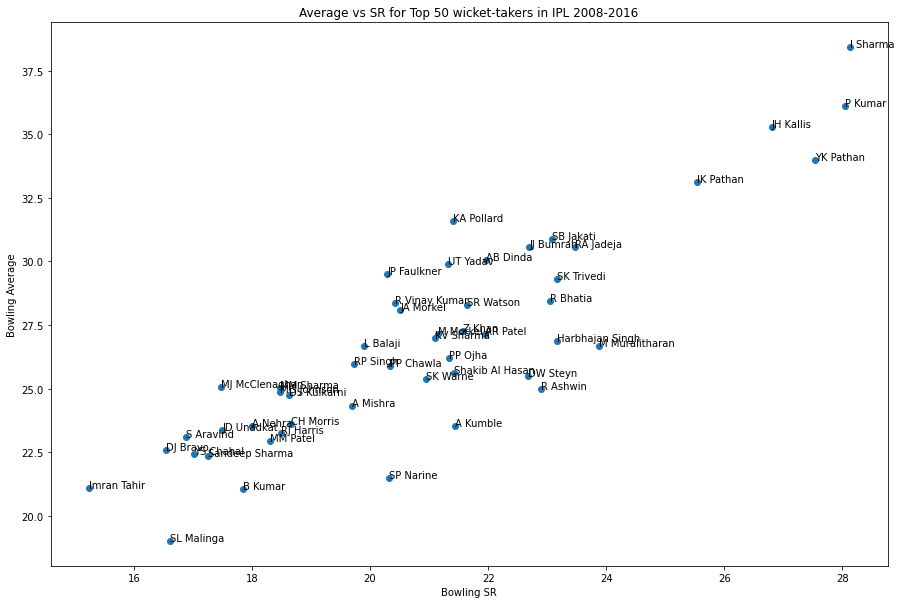

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(wicket_takers["Strike Rate"], wicket_takers["Average"])
ax.set_xlabel("Bowling SR")
ax.set_ylabel("Bowling Average")
ax.set_title("Average vs SR for Top 50 wicket-takers in IPL 2008-2016")

for i, bowler in enumerate(wicket_takers["Name"]):
    ax.annotate(bowler, (wicket_takers["Strike Rate"].iloc[i], wicket_takers["Average"].iloc[i]))

fig.show()

### Top 50 Wicket Takers: Average vs Economy

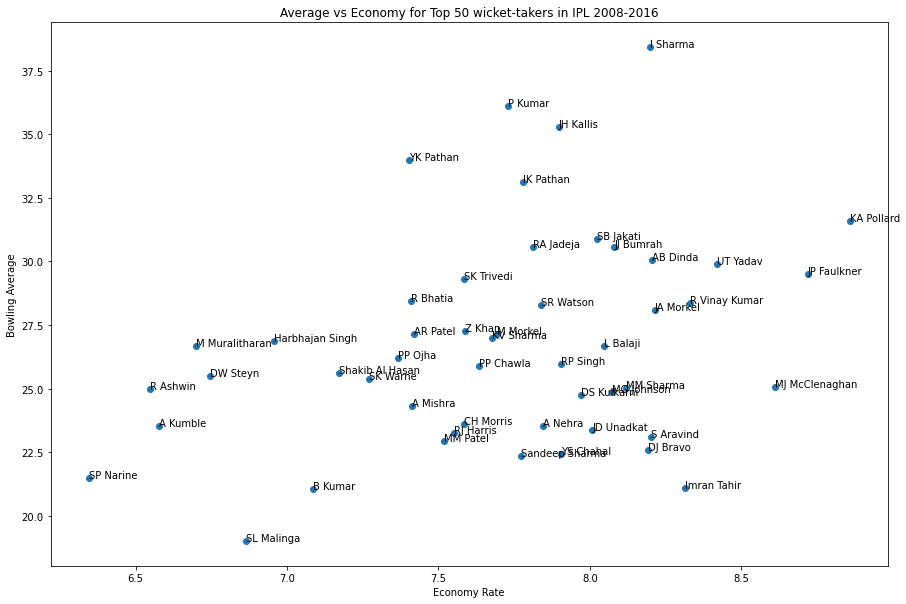

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(wicket_takers["Economy"], wicket_takers["Average"])
ax.set_xlabel("Economy Rate")
ax.set_ylabel("Bowling Average")
ax.set_title("Average vs Economy for Top 50 wicket-takers in IPL 2008-2016")

for i, bowler in enumerate(wicket_takers["Name"]):
    ax.annotate(bowler, (wicket_takers["Economy"].iloc[i], wicket_takers["Average"].iloc[i]))

fig.show()

### Top 50 Wicket Takers: Strike Rate vs Economy

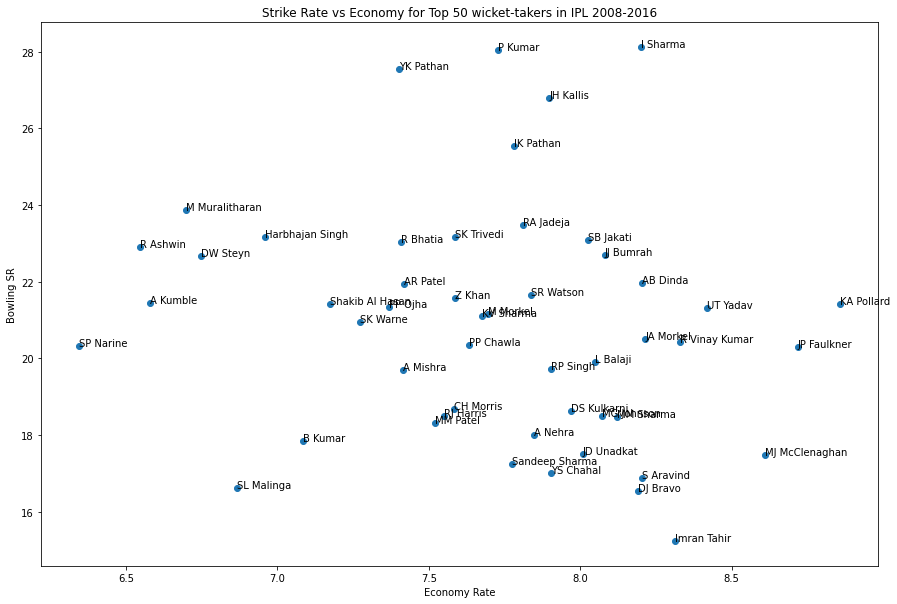

In [44]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(wicket_takers["Economy"], wicket_takers["Strike Rate"])
ax.set_xlabel("Economy Rate")
ax.set_ylabel("Bowling SR")
ax.set_title("Strike Rate vs Economy for Top 50 wicket-takers in IPL 2008-2016")

for i, bowler in enumerate(wicket_takers["Name"]):
    ax.annotate(bowler, (wicket_takers["Economy"].iloc[i], wicket_takers["Strike Rate"].iloc[i]))

fig.show()

## Simplistic Simulator

Assume, stupidly, that everything is independent. Create joint distribution using batsman and bowler distributions for 0's to 6's.

Squads based on CSK vs RCB: IPL 2011 final

CSK:
- Michael Hussey
- Murali Vijay
- Suresh Raina
- S Badrinath
- Wriddhiman Saha
- MS Dhoni (c & wk)
- Dwayne Bravo
- Albie Morkel
- Ravichandran Ashwin
- Shadab Jakati
- Doug Bollinger


RCB: 
- Chris Gayle
- Mayank Agarwal
- Virat Kohli
- AB de Villiers (wk)
- Luke Pomersbach
- Saurabh Tiwary
- Daniel Vettori (c)
- Sreenath Aravind
- Abhimanyu Mithun
- Zaheer Khan
- JS Mohammad


In [0]:
rcb = ["CH Gayle", "MA Agarwal", "V Kohli", "AB de Villiers", "LA Pomersbach", "SS Tiwary", "DL Vettori", "S Aravind", "A Mithun", "Z Khan", "J Syed Mohammad"]
csk = ["MEK Hussey", "M Vijay", "SK Raina", "S Badrinath", "WP Saha", "MS Dhoni", "DJ Bravo", "JA Morkel", "R Ashwin", "SB Jakati", "DE Bollinger"]

rcb_bowlers = rcb[-5:]
csk_bowlers = csk[-5:]

csk_bat_scorecard = {}
rcb_bowl_scorecard = {}

rcb_bat_scorecard = {}
csk_bowl_scorecard = {}

eps = 0.000000001

tables = {}
dismissal_tables = {}
valid_dismissals = bowler_dismissals + ["run out"]

# Tables have (batsmen, bowler) pairs as keys and probabilities as values
for rcb_batsman in rcb:
    for csk_bowler in csk_bowlers:
        bat_srs = batsmen_df[batsmen_df["Name"] == rcb_batsman]
        bowl_srs = bowlers_df[bowlers_df["Name"] == csk_bowler]
        mat = np.zeros((10,))
        for i in range(7):
            prob = (bat_srs[i].values[0] / bat_srs["Balls Faced"].values[0]) + (bowl_srs[i].values[0] / bowl_srs["Balls Bowled"].values[0])
            mat[i] = prob
        
        mat[7] = (bat_srs["Dismissals"].values[0] / bat_srs["Balls Faced"].values[0]) + (bowl_srs["Wickets"].values[0] / bowl_srs["Balls Bowled"].values[0])
        mat[8] = bowl_srs["No Balls"].values[0] / bowl_srs["Balls Bowled"].values[0]
        mat[9] = bowl_srs["Wides"].values[0] / bowl_srs["Balls Bowled"].values[0]
        
        mat += eps
        mat /= np.sum(mat)
        tables[(rcb_batsman, csk_bowler)] = mat

        dmat = np.zeros((len(valid_dismissals),))
        for i, d in enumerate(valid_dismissals):
            if d == "run out":
                dmat[i] = (bat_srs["run out"].values[0] / bat_srs["Dismissals"].values[0]) * 2
            else:
                dmat[i] = (bat_srs[d].values[0] / bat_srs["Dismissals"].values[0]) + (bowl_srs[d].values[0] / bowl_srs["Wickets"].values[0])

        dmat += eps
        dmat /= np.sum(dmat)
        
        dismissal_tables[(rcb_batsman, csk_bowler)] = dmat

        rcb_bat_scorecard[rcb_batsman] = {"Runs":0,
                                          "Balls":0,
                                          "Dismissal type": None}
        
        csk_bowl_scorecard[csk_bowler] = {"Balls":0,
                                          "Dots":0,
                                          "Runs":0,
                                          "Wickets":0}
        



for csk_batsman in csk:
    for rcb_bowler in rcb_bowlers:
        bat_srs = batsmen_df[batsmen_df["Name"] == csk_batsman]
        bowl_srs = bowlers_df[bowlers_df["Name"] == rcb_bowler]
        mat = np.zeros((10,))
        for i in range(7):
            prob = (bat_srs[i].values[0] / bat_srs["Balls Faced"].values[0]) + (bowl_srs[i].values[0] / bowl_srs["Balls Bowled"].values[0])
            mat[i] = prob
        
        mat[7] = (bat_srs["Dismissals"].values[0] / bat_srs["Balls Faced"].values[0]) + (bowl_srs["Wickets"].values[0] / bowl_srs["Balls Bowled"].values[0])
        mat[8] = bowl_srs["No Balls"].values[0] / bowl_srs["Balls Bowled"].values[0]
        mat[9] = bowl_srs["Wides"].values[0] / bowl_srs["Balls Bowled"].values[0]
        
        mat += eps
        mat /= np.sum(mat)
        tables[(csk_batsman, rcb_bowler)] = mat

        dmat = np.zeros((len(valid_dismissals),))
        for i, d in enumerate(valid_dismissals):
            if d == "run out":
                dmat[i] = (bat_srs["run out"].values[0] / bat_srs["Dismissals"].values[0]) * 2
            else:
                dmat[i] = (bat_srs[d].values[0] / bat_srs["Dismissals"].values[0]) + (bowl_srs[d].values[0] / bowl_srs["Wickets"].values[0])
        
        dmat += eps
        dmat /= np.sum(dmat)

        dismissal_tables[(csk_batsman, rcb_bowler)] = dmat

        csk_bat_scorecard[csk_batsman] = {"Runs":0,
                                          "Balls":0,
                                          "Dismissal type": None}
        
        rcb_bowl_scorecard[rcb_bowler] = {"Balls":0,
                                          "Dots":0,
                                          "Runs":0,
                                          "Wickets":0}

In [0]:
# First Innings
# CSK bats first

file_lines = []
file_lines.append("CSK is batting first")
file_lines.append("CSK: ")
for c in csk:
    file_lines.append(c)
file_lines.append("\nRCB:")
for r in rcb:
    file_lines.append(r)

file_lines.append("--------")


striker = csk[0]
non_striker = csk[1]

bb_1 = 0
wk_1 = 0
total_1 = 0


prev_bowler = None
curr_bowler = None

bowl_list = rcb_bowlers * 4

while bb_1 < 120 and wk_1 < 10:
    # Pre Over processing
    curr_bowler = np.random.choice(bowl_list)
    while curr_bowler == prev_bowler or rcb_bowl_scorecard[curr_bowler]["Balls"] >= 24:
        curr_bowler = np.random.choice(bowl_list)

    bowl_list.remove(curr_bowler)
    legal_balls = 0

    while legal_balls < 6 and wk_1 < 10:
        ball = random.choices(np.arange(10), weights = tables[(striker, curr_bowler)])[0]
        if ball <= 6:
            # Runs
            legal_balls += 1
            total_1 += ball
            file_lines.append(f"{bb_1 // 6}.{legal_balls}: {curr_bowler} to {striker}: {ball} runs.")

            csk_bat_scorecard[striker]["Runs"] += ball
            csk_bat_scorecard[striker]["Balls"] += 1
            rcb_bowl_scorecard[curr_bowler]["Runs"] += ball
            rcb_bowl_scorecard[curr_bowler]["Balls"] += 1

            if ball == 0:
                rcb_bowl_scorecard[curr_bowler]["Dots"] += 1

            if ball % 2 == 1:
                striker, non_striker = non_striker, striker


        elif ball == 7:
            # OUT
            legal_balls += 1
            dismissal_index = random.choices(np.arange(len(valid_dismissals)), weights=dismissal_tables[(striker, curr_bowler)])[0]
            file_lines.append(f"{bb_1 // 6}.{legal_balls}: {curr_bowler} to {striker}: OUT.")

            csk_bat_scorecard[striker]["Balls"] += 1
            csk_bat_scorecard[striker]["Dismissal type"] = valid_dismissals[dismissal_index]

            rcb_bowl_scorecard[curr_bowler]["Balls"] += 1
            if valid_dismissals[dismissal_index] != "run out":
                rcb_bowl_scorecard[curr_bowler]["Wickets"] += 1
            rcb_bowl_scorecard[curr_bowler]["Dots"] += 1

            wk_1 += 1
            if wk_1 < 10:
                striker = csk[wk_1 + 1]
            else:
                break


        elif ball == 8:
            # No Ball
            total_1 += 1
            file_lines.append(f"{bb_1 // 6}.{legal_balls}: {curr_bowler} to {striker}: No Ball.")
            rcb_bowl_scorecard[curr_bowler]["Runs"] += 1

        elif ball == 9:
            # Wide
            total_1 += 1
            file_lines.append(f"{bb_1 // 6}.{legal_balls}: {curr_bowler} to {striker}: Wide.")
            rcb_bowl_scorecard[curr_bowler]["Runs"] += 1







    # Post over processing
    striker, non_striker = non_striker, striker
    prev_bowler = curr_bowler
    curr_bowler = None
    bb_1 += legal_balls
    file_lines.append(f"\nCSK: {total_1}/{wk_1} in {bb_1 // 6}.{bb_1 % 6} overs.")


In [167]:
# Second Innings
# RCB bats 
file_lines.append("--------")
file_lines.append("--------")
file_lines.append(f"CSK have scored {total_1} for {wk_1} in {bb_1 // 6 }.{bb_1 % 6} overs. RCB have to chase {total_1 + 1} in 20 overs to win.")
file_lines.append("--------")
file_lines.append("--------")


striker = rcb[0]
non_striker = rcb[1]

bb_2 = 0
wk_2 = 0
total_2 = 0
target = total_1 + 1

prev_bowler = None
curr_bowler = None

bowl_list = csk_bowlers * 4

while bb_2 < 120 and wk_2 < 10 and total_2 < target:
    # Pre Over processing
    curr_bowler = np.random.choice(bowl_list)
    while curr_bowler == prev_bowler or csk_bowl_scorecard[curr_bowler]["Balls"] >= 24:
        curr_bowler = np.random.choice(bowl_list)        

    legal_balls = 0
    bowl_list.remove(curr_bowler)

    while legal_balls < 6 and wk_2 < 10 and total_2 < target:
        ball = random.choices(np.arange(10), weights = tables[(striker, curr_bowler)])[0]
        if ball <= 6:
            # Runs
            total_2 += ball
            legal_balls += 1   
            file_lines.append(f"{bb_2 // 6}.{legal_balls}: {curr_bowler} to {striker}: {ball} runs.")

            rcb_bat_scorecard[striker]["Runs"] += ball
            rcb_bat_scorecard[striker]["Balls"] += 1
            csk_bowl_scorecard[curr_bowler]["Runs"] += ball
            csk_bowl_scorecard[curr_bowler]["Balls"] += 1

            if ball == 0:
                csk_bowl_scorecard[curr_bowler]["Dots"] += 1

            if ball % 2 == 1:
                striker, non_striker = non_striker, striker


        elif ball == 7:
            # OUT
            legal_balls += 1
            file_lines.append(f"{bb_2 // 6}.{legal_balls}: {curr_bowler} to {striker}: OUT.")
            dismissal_index = random.choices(np.arange(len(valid_dismissals)), weights=dismissal_tables[(striker, curr_bowler)])[0]

            rcb_bat_scorecard[striker]["Balls"] += 1
            rcb_bat_scorecard[striker]["Dismissal type"] = valid_dismissals[dismissal_index]

            csk_bowl_scorecard[curr_bowler]["Balls"] += 1
            if valid_dismissals[dismissal_index] != "run out":
                csk_bowl_scorecard[curr_bowler]["Wickets"] += 1
            csk_bowl_scorecard[curr_bowler]["Dots"] += 1


            
            wk_2 += 1
            if wk_2 < 10:
                striker = rcb[wk_2 + 1]

        elif ball == 8:
            # No Ball
            total_2 += 1
            file_lines.append(f"{bb_2 // 6}.{legal_balls}: {curr_bowler} to {striker}: No Ball.")
            csk_bowl_scorecard[curr_bowler]["Runs"] += 1

        elif ball == 9:
            # Wide
            total_2 += 1
            file_lines.append(f"{bb_2 // 6}.{legal_balls}: {curr_bowler} to {striker}: Wide.")
            csk_bowl_scorecard[curr_bowler]["Runs"] += 1







    # Post over processing
    striker, non_striker = non_striker, striker
    prev_bowler = curr_bowler
    curr_bowler = None
    bb_2 += legal_balls
    file_lines.append("----------")
    file_lines.append(f"RCB: {total_2}/{wk_2} in {bb_2 // 6}.{bb_2 % 6} overs. RCB need {target - total_2} in {120 - (bb_2)} balls to win.")
    file_lines.append("----------")


if total_2 < target:
    file_lines.append("----------")
    file_lines.append("----------")
    file_lines.append(f"CSK win by {total_1 - total_2} runs.")
    file_lines.append("----------")
    file_lines.append("----------")
elif total_2 == total_1:
    file_lines.append("----------")
    file_lines.append("----------")
    file_lines.append(f"Match Tied.")
    file_lines.append("----------")
    file_lines.append("----------")
else:
    file_lines.append("----------")
    file_lines.append("----------")
    file_lines.append(f"RCB win by {10 - wk_2} wickets.")
    file_lines.append("----------")
    file_lines.append("----------")


KeyboardInterrupt: ignored

In [0]:
file_lines.append("SCORECARD")
file_lines.append("----------")
file_lines.append("----------")
file_lines.append("CSK Batting")
file_lines.append("----------")
for c in csk:
    if csk_bat_scorecard[c]["Dismissal type"] is None:
        if csk_bat_scorecard[c]["Balls"]  > 0:
            file_lines.append(c + ((15 - len(c))*" ") + "|" + (20 * " ") + "| " +
                          str(csk_bat_scorecard[c]["Runs"])  + "*" + 
                          "(" + str(csk_bat_scorecard[c]["Balls"]) + ")" )
        else:
            file_lines.append(c + ((15 - len(c))*" ") + "|" + (20 * " ") + "| " +
                          str(csk_bat_scorecard[c]["Runs"]) + 
                          "(" + str(csk_bat_scorecard[c]["Balls"]) + ")" )
    else:
        file_lines.append(c + ((15 - len(c))*" ") + "|" + ((20 - len(csk_bat_scorecard[c]["Dismissal type"])) * " ") +
                          csk_bat_scorecard[c]["Dismissal type"] + "| " +
                          str(csk_bat_scorecard[c]["Runs"])  + 
                          "(" + str(csk_bat_scorecard[c]["Balls"]) + ")" )

file_lines.append("--------")
file_lines.append(f"CSK: {total_1}/ {wk_1} in {bb_1 // 6 }.{bb_1 % 6} ov.")
file_lines.append("--------")
file_lines.append("--------")
file_lines.append("RCB Bowling")
file_lines.append("--------")

for r in rcb_bowlers:
    file_lines.append(r + ((15 - len(r))*" ") + "|" +
                       ((5 - (0 if rcb_bowl_scorecard[r]["Balls"] < 10 else 1)) * " ") + str(rcb_bowl_scorecard[r]["Balls"] // 6) + "." + str(rcb_bowl_scorecard[r]["Balls"] % 6) + "|" +
                           ((5 - (0 if rcb_bowl_scorecard[r]["Dots"] < 10 else 1)) * " ") + str(rcb_bowl_scorecard[r]["Dots"])  + "|" +
                           ((5 - (0 if rcb_bowl_scorecard[r]["Runs"] < 10 else 1)) * " ") + str(rcb_bowl_scorecard[r]["Runs"])  + "|" + 
                           ((5 - (0 if rcb_bowl_scorecard[r]["Wickets"] < 10 else 1)) * " ") + str(rcb_bowl_scorecard[r]["Wickets"]))


In [0]:
file_lines.append("----------")
file_lines.append("----------")
file_lines.append("RCB Batting")
file_lines.append("----------")
for r in rcb:
    if rcb_bat_scorecard[r]["Dismissal type"] is None:
        if rcb_bat_scorecard[r]["Balls"]  > 0:
            file_lines.append(r + ((15 - len(r))*" ") + "|" + (20 * " ") + "| " +
                          str(rcb_bat_scorecard[r]["Runs"])  + "*" + 
                          "("  + str(rcb_bat_scorecard[r]["Balls"]) + ")" )
        else:
            file_lines.append(r + ((15 - len(r))*" ") + "|" + (20 * " ") + "| " +
                          str(rcb_bat_scorecard[r]["Runs"]) + 
                          "(" + str(rcb_bat_scorecard[r]["Balls"]) + ")" )
    else:
        file_lines.append(r + ((15 - len(r))*" ") + "|" + ((20 - len(rcb_bat_scorecard[r]["Dismissal type"])) * " ") +
                          rcb_bat_scorecard[r]["Dismissal type"] + "| " +
                          str(rcb_bat_scorecard[r]["Runs"])  + 
                          "(" + str(rcb_bat_scorecard[r]["Balls"]) + ")" )

file_lines.append("--------")
file_lines.append(f"RCB: {total_2}/ {wk_2} in {bb_2 // 6 }.{bb_2 % 6} ov.")
file_lines.append("--------")
file_lines.append("--------")
file_lines.append("CSK Bowling")
file_lines.append("--------")

for c in csk_bowlers:
    file_lines.append(c + ((15 - len(c))*" ") + "|" +
                          ((5 - (0 if csk_bowl_scorecard[c]["Balls"] < 10 else 1)) * " ") + str(csk_bowl_scorecard[c]["Balls"] // 6) + "." +str(csk_bowl_scorecard[c]["Balls"] % 6) + "|" + 
                          ((5 - (0 if csk_bowl_scorecard[c]["Dots"] < 10 else 1)) * " ") + str(csk_bowl_scorecard[c]["Dots"])  + "|" +
                          ((5 - (0 if csk_bowl_scorecard[c]["Runs"] < 10 else 1)) * " ") + str(csk_bowl_scorecard[c]["Runs"])  + "|" +
                          ((5 - (0 if csk_bowl_scorecard[c]["Wickets"] < 10 else 1)) * " ") + str(csk_bowl_scorecard[c]["Wickets"]))

file_lines.append("--------")
file_lines.append("--------")

In [0]:
import os
i = 0
prefix = "/content/drive/My Drive/Simplistic Simulation Results/"
filename = f"CSK_vs_RCB_scorecard_{i}.txt"
while filename in os.listdir(prefix):
    i += 1
    filename = f"CSK_vs_RCB_scorecard_{i}.txt"

with open(prefix + filename,'w') as f:
    for line in file_lines:
        f.write(line)
        f.write("\n")